In [98]:
import random
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from helpers import eig
from sklearn.cluster import KMeans

# Exercise 4

(1000, 1)
(784, 1000)


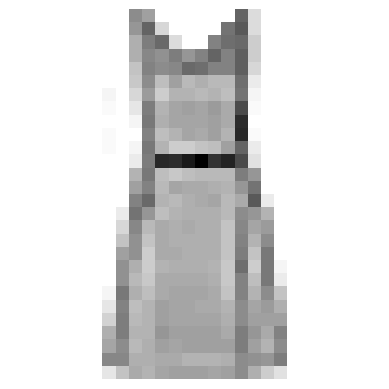

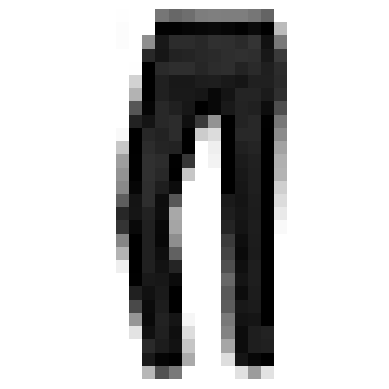

In [99]:
mat = scipy.io.loadmat('hw2_zalando_new.mat')

correct = mat['correct']
items = mat['items']

print(correct.shape)
print(items.shape)


def zalando_plot(z):
    n = 28  # Image size
    A = np.reshape(z, (n, n))

    # Normalize it
    I = np.argmax(np.abs(z))
    za = z[I]
    A = A / za

    B = 1 - A # It looks nicer with a white background.

    # Plot
    plt.imshow(B, cmap='gray', origin='upper')
    plt.axis('off')
    plt.show()

zalando_plot(items[:,0])
zalando_plot(items[:,1])


Clearly pants and dresses are the two items in the dataset

In [100]:
def build_distance(items, w):  #Vectorized way of computing distance
    w = np.array([w]).T
    items = w * items
    S = np.sum(items**2, axis=0, keepdims=True)
    S = np.sqrt(np.maximum(0,(S + S.T - 2 * items.T.dot(items))))   #maximum just to silence the warning message of possible negative values inside (np.sqrt)
    np.fill_diagonal(S, 0)
    return S

# Here is a slower but more intuitive way of computing the distances:
"""
def build_distance(items, w):
    num_points = items.shape[1]
    S = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i, num_points):
            dist = np.linalg.norm(w * (items[:, i] - items[:, j]))
            S[i, j] = dist
            S[j, i] = dist
    return S
""" 

w = np.ones(items[:,1].shape[0])
S= build_distance(items, w)

### B)

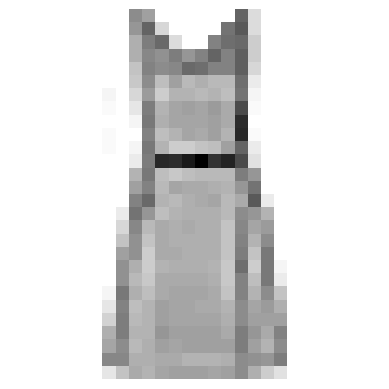

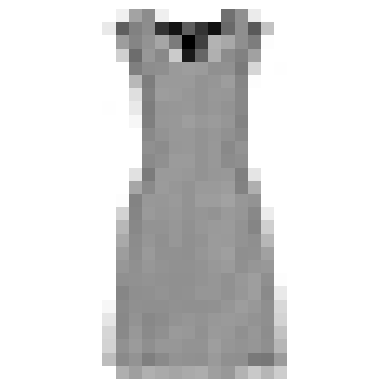

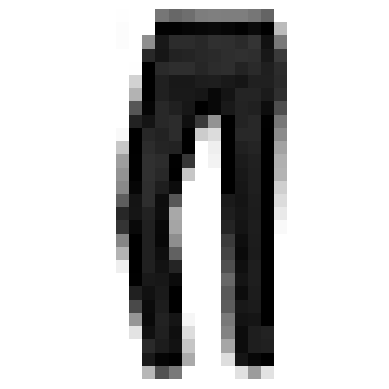

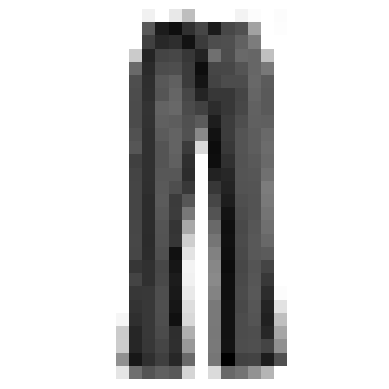

In [101]:
# First item:
zalando_plot(items[:,0])

# Closest to first item:
index = np.argmin(S[0,1:]) + 1
zalando_plot(items[:,index])

# Second item:
zalando_plot(items[:,1])

# Closest to second item
index = np.argmin(S[1,2:]) + 1
zalando_plot(items[:,index])

In [102]:
def build_weights(S):  # Quicker vectorized version
    alpha = 0.5
    W = np.zeros(S.shape)
    sigma = np.std(S, axis = 1)
    W = np.exp(-alpha*S**2/sigma**2)
    W -= np.diag(np.diag(W))
    W = (W+W.T)/2
    return W

def build_weights_slow(S): # Slow but intuitive version
    W = np.zeros(S.shape)
    alpha = 0.5
    for i in range(S.shape[0]):
        sigma = np.std(S[:,i])
        for j in range(S.shape[0]):
            W[i,j] = np.exp((-alpha*S[i,j]**2)/(sigma**2))
    W -= np.diag(np.diag(W))
    W = (W+W.T)/2
    return W

import time

start_time = time.time()
W = build_weights_slow(S)
end_time = time.time()

print(W)
print("Elapsed time slow version: {:.2f} seconds".format(end_time - start_time))

[[0.00000000e+00 2.68312481e-07 1.36933751e-07 ... 6.08580244e-04
  3.25116019e-07 1.76428491e-07]
 [2.68312481e-07 0.00000000e+00 5.93980936e-03 ... 1.80088118e-05
  2.13960027e-05 2.56437328e-01]
 [1.36933751e-07 5.93980936e-03 0.00000000e+00 ... 1.75153947e-05
  2.34822478e-04 3.94580792e-03]
 ...
 [6.08580244e-04 1.80088118e-05 1.75153947e-05 ... 0.00000000e+00
  3.83932734e-06 1.15323883e-05]
 [3.25116019e-07 2.13960027e-05 2.34822478e-04 ... 3.83932734e-06
  0.00000000e+00 1.60736469e-05]
 [1.76428491e-07 2.56437328e-01 3.94580792e-03 ... 1.15323883e-05
  1.60736469e-05 0.00000000e+00]]
Elapsed time slow version: 1.64 seconds


In [103]:
start_time = time.time()
W = build_weights(S)
end_time = time.time()

print(W)
print("Elapsed time fast version: {:.2f} seconds".format(end_time - start_time))

[[0.00000000e+00 2.68312481e-07 1.36933751e-07 ... 6.08580244e-04
  3.25116019e-07 1.76428491e-07]
 [2.68312481e-07 0.00000000e+00 5.93980936e-03 ... 1.80088118e-05
  2.13960027e-05 2.56437328e-01]
 [1.36933751e-07 5.93980936e-03 0.00000000e+00 ... 1.75153947e-05
  2.34822478e-04 3.94580792e-03]
 ...
 [6.08580244e-04 1.80088118e-05 1.75153947e-05 ... 0.00000000e+00
  3.83932734e-06 1.15323883e-05]
 [3.25116019e-07 2.13960027e-05 2.34822478e-04 ... 3.83932734e-06
  0.00000000e+00 1.60736469e-05]
 [1.76428491e-07 2.56437328e-01 3.94580792e-03 ... 1.15323883e-05
  1.60736469e-05 0.00000000e+00]]
Elapsed time fast version: 0.04 seconds


### C)

(0.00098, 0.00102)

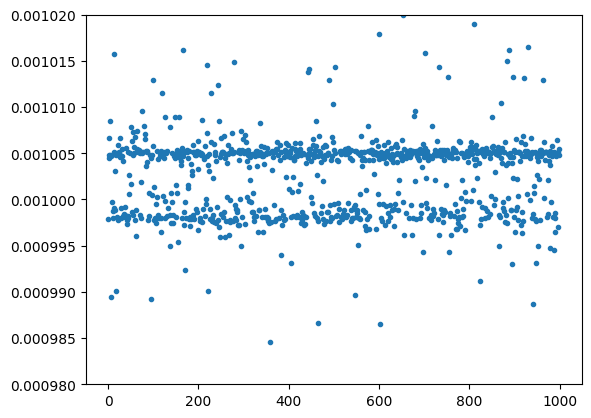

In [104]:
D = np.diag(np.sum(W, axis = 1))
L = D - W 

eigvals, eigvectors = eig(L)

xvals = np.zeros((eigvectors.shape[0],1))
plt.plot(eigvectors[:,1], '.')
plt.ylim(bottom = 0.00098, top = 0.00102)

### D)

In [105]:
tau = np.median(eigvectors[:,1])
predictions = 1*(eigvectors[:,1] < tau)
correct_adj = (correct-1).T[0]
accuracy = np.mean(predictions == correct_adj)
print(f'Accuracy: {accuracy*100}%')

Accuracy: 82.0%


If we do the same procedure with an eigenvector such as the 5:th one, we get a better accuracy:

In [106]:
tau5 = np.median(eigvectors[:,4])
predictions5 = 1*(eigvectors[:,4] > tau5)
accuracy5 = np.mean(predictions5 == correct_adj)
print(f'Accuracy: {accuracy5*100}%')

Accuracy: 96.2%


We could also compare the results above with a kNN + K-means approach, such as in exercise 3. In that case we get an even better accuracy:

Accuracy: 99.9%


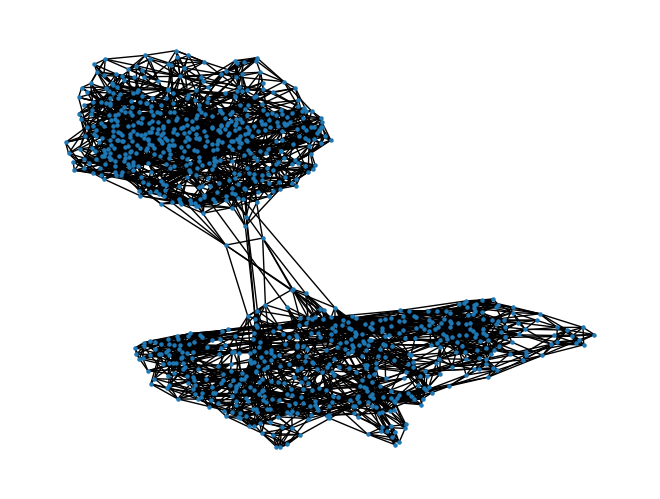

In [107]:
def knn(Dist, k):
    n = Dist.shape[0]
    W = np.zeros((n, n))
    knn_indices = np.argsort(Dist, axis=1)[:, :k+1]
    
    for i in range(n):
        W[i, knn_indices[i, 1:]] = 1
        W[knn_indices[i, 1:], i] = 1
    return W 

W = knn(S, 6)    # Here we choose a neighbourhood of 6, but could be changed to another number of course
G = nx.from_numpy_array(W)
nx.draw(G, node_size = 5)

def cluster(W, k):
    D = np.diag(np.sum(W, axis = 1))
    L = D - W
    _, eigvectors = eig(L)
    U = eigvectors[:,:k]
    kmeans = KMeans(n_clusters = k).fit(U)    # Using sklearn's K-means algorithm
    return kmeans.labels_

clusters = cluster(W, 2)

accuracy = np.mean(clusters == correct_adj)
if accuracy < 0.5:
    accuracy = 1 - accuracy

print(f'Accuracy: {accuracy * 100}%')

### E)

In [108]:
def transform_zalando(z):  #Re-define Zalando_plot to return "plottable" matrix
    n = 28  # Image size
    A = np.reshape(z, (n, n))

    # Normalize it
    I = np.argmax(np.abs(z))
    za = z[I]
    A = A / za

    B = 1 - A # It looks nicer with a white background.
    return B

In [109]:
vec = 1 * (predictions != correct_adj)
wrong_guesses = vec.nonzero()[0]

In [110]:
idxs = [random.randrange(len(wrong_guesses)) for _ in range(4)]
II = wrong_guesses[idxs]
imagesd = {
    idx: {
        "prediction": predictions[idx],
        "actual": correct_adj[idx]
    }
    for idx in II
}
imagesd

{639: {'prediction': 1, 'actual': 0},
 756: {'prediction': 1, 'actual': 0},
 317: {'prediction': 0, 'actual': 1},
 886: {'prediction': 1, 'actual': 0}}

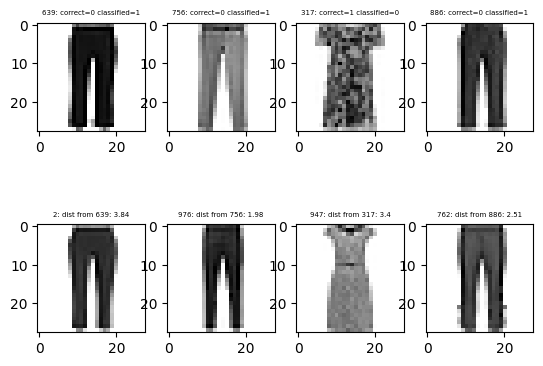

In [111]:
fig, axs = plt.subplots(2, 4)

for i, image_idx in enumerate(imagesd):
    # Plot items
    d = imagesd[image_idx]
    axs[0, i].imshow(transform_zalando(items[:,image_idx]),cmap='gray', origin='upper')
    axs[0, i].set_title(f'{image_idx}: correct={d["actual"]} classified={d["prediction"]}', fontsize=5)

for i, image_idx in enumerate(imagesd):
    # Subset item class
    item = items[:, [image_idx]]
    item_predicted_class = predictions[image_idx]

    # Subset relevant items to compare + do comparison
    relevant_comparison_items = items[:, (correct_adj != item_predicted_class)]
    a = np.tile(item, (1, relevant_comparison_items.shape[1]))
    norms = np.linalg.norm(a - relevant_comparison_items, axis=0)
    norms = norms[norms != 0]
    closest_idx, dist = norms.argmin(), norms.min()
    closest_item = relevant_comparison_items[:, [closest_idx]]

    # Find original index
    closest_item_mat = np.tile(closest_item, (1, 1000))
    closest_item_norm = np.linalg.norm(closest_item_mat - items, axis=0)
    closest_item_orig_idx = np.argmax(closest_item_norm == 0)

    # Plot the closest item from the other class
    axs[1, i].imshow(transform_zalando(closest_item),cmap='gray', origin='upper')
    axs[1, i].set_title(f'{closest_item_orig_idx}: dist from {image_idx}: {round(dist, 2)}', fontsize=5)

### F)

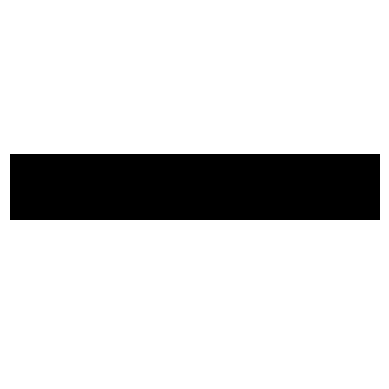

In [114]:
x = 2
W_weight = np.ones((28, 28))
W_weight[11:16,:] = x
w_weight = W_weight.ravel()
w_weight = w_weight / np.linalg.norm(w_weight)
zalando_plot(w_weight)

The plot above shows that the weight matrix put an increased in the middle of the zalando_items, which probably is the area where they differ the most. Therefore we hope that using this weighting will controbute to a better accuracy and a clearer separation in plots like the one in part d

Accuracy: 91.2%


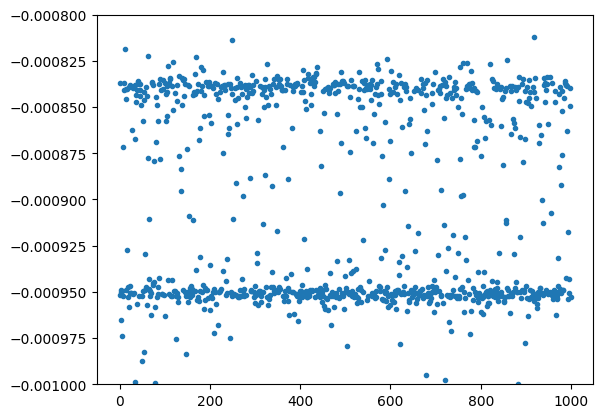

In [124]:
S = build_distance(items, w_weight)
W = build_weights(S)
D = np.diag(np.sum(W, axis = 1))
L = D - W 

eigvals, eigvectors = eig(L)


xvals = np.zeros((eigvectors.shape[0],1))
plt.plot(eigvectors[:,1], '.')
plt.ylim(bottom = -0.001, top = -0.0008)


tau = np.median(eigvectors[:,1])
predictions = 1*(eigvectors[:,1] > tau)
correct_adj = (correct-1).T[0]
accuracy = np.mean(predictions == correct_adj)
print(f'Accuracy: {accuracy*100}%')

### F - bonus

Another alternative which could generate an even better accuracy is if we weigh the lower part of the image more, since the difference between dresses and pants is probably most obvious when looking at the lowest part.

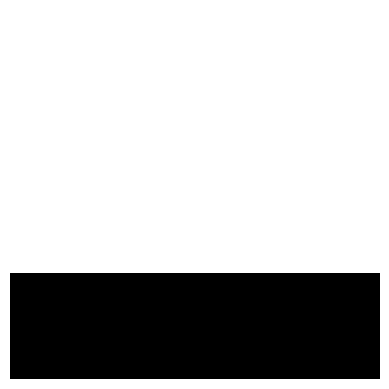

In [125]:
x = 2
W_weight = np.ones((28, 28))
W_weight[20:,:] = x
w_weight = W_weight.ravel()
w_weight = w_weight / np.linalg.norm(w_weight)
zalando_plot(w_weight)

Accuracy: 98.4%


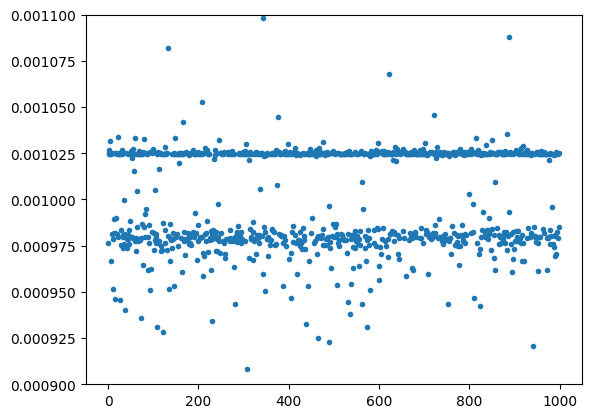

In [134]:
S = build_distance(items, w_weight)
W = build_weights(S)
D = np.diag(np.sum(W, axis = 1))
L = D - W 

eigvals, eigvectors = eig(L)


xvals = np.zeros((eigvectors.shape[0],1))
plt.plot(eigvectors[:,1], '.')
plt.ylim(bottom = 0.0009, top = 0.0011)


tau = np.median(eigvectors[:,1])
predictions = 1*(eigvectors[:,1] < tau)
correct_adj = (correct-1).T[0]
accuracy = np.mean(predictions == correct_adj)
print(f'Accuracy: {accuracy*100}%')